## Signal Prediction


**Problem definition:** given 120 historical timestamps with signal classes, predict change in signal for the next 30 steps ahead.

**Dataset description:**

* Total number of instances: 86400
* Training set: 70%
* Validation set: 20%
* Test set: 10%
* Timestamp - a value representing seconds
* D1, D2, D3, D4 - attribute values
* K1, K2, K3, K4 - target values 

Problem settings: predict such tagret virables as **'K01R', 'K02', 'K03'** based on such features as 'timestamp/Uhrzeit' (TX).


*   **BK02**: Bemessung für K02 (Interner Detektor **D21/22**)
*   **ANF_K03**: Anforderung für K03 (D32/32 will be reset at Green Start and Green End) 
*   **ZYK**: cycle time

K01R status: R->S->G->A->R (A: Achtung; S: Start; G: Grün; R: Rot), only Green is 1, other status will be set to 0

**Class 1:** green (the vehicle is free to pass the intersection)

**Class 0:** red, yellow, yellow_green (the vehicle must stop)

This notebook consists of the implementation of the following **models**:

* Multilayer dense neural network (Dense)
* Convolutional neural network (CNN)
* Long short term memory (LSTM)
* Support vector machine (SVM) (in progress)
* Adaptive Neuro-Fuzzy Inference System (ANFIS) (in progress)
* Hybrid models (CNN + LSTM, AR + LSTM, etc.) (in progress)

After performance evaluation, the final model will be chosen.

Abstract: this work compares different machine learning models accuracy，including binary accuracy, confusion matrix, basic metrics (F1 score, Matthew's correlation coefficient, ROC curve...)

In [ ]:
# set a target variable 'K1', 'K2', 'K3', 'K4'
trg = 'K01R'

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow import feature_column
from tensorflow.keras import layers
import keras.optimizers
mpl.style.use('bmh')

mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False

# for downloading a file from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# get access to google drive to read data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading data from google drive, replace the file to your own
df = pd.read_csv('data/2021-12-14-L0125(processed).CSV', low_memory=False)

# basic statistical analysis
# data preparation / cleaning
df=df.drop(columns=['Uhrzeit'])
df

,K01R,K02,K03,K04L,K05,K06L,K07,K08L,K10R,K11R,...,MPN_10,MPN_9,MPN_8,MPN_7,MPN_6,MPN_5,MPN_4,MPN_3,MPN_2,MPN_1
0,R,R,G,G,R,R,R,R,D,G,...,0,0,0,0,0,0,0,0,0,0
1,R,R,A,G,R,R,R,R,D,G,...,0,0,0,0,0,0,0,0,0,0
2,R,R,A,G,R,R,R,R,D,G,...,0,0,0,0,0,0,0,0,0,0
3,R,R,A,G,R,R,R,R,D,G,...,0,0,0,0,0,0,0,0,0,0
4,R,R,R,G,R,R,R,R,D,G,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,G,R,R,R,R,R,G,G,D,D,...,0,0,0,0,0,0,0,0,0,0
86396,G,R,R,R,R,R,G,G,D,D,...,0,0,0,0,0,0,0,0,0,0
86397,A,R,R,R,R,R,A,G,D,D,...,0,0,0,0,0,0,0,0,0,0
86398,A,R,R,R,R,R,A,G,D,D,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# add time frame (as index)
df['timestamp'] = df.index
col_name="timestamp"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)

# re-transforming the problem to binary classification
# red, yellow and yellow_red attibutes = 0, green = 1

df.replace('G', '1', inplace=True, regex=True)
df.replace('R', '0', inplace=True, regex=True)
df.replace('A', '0', inplace=True, regex=True)
# acoustic signal for Blinde Lampe
df.replace('a', '1', inplace=True, regex=True)
df.replace('S', '0', inplace=True, regex=True)
df.replace('D', '0', inplace=True, regex=True)

df['ANF_R01'][df.ANF_R01>0]=1
df['ANF_R05'][df.ANF_R05>0]=1
df['OML.V.ANF_S03'][df['OML.V.ANF_S03']>0]=1
df['OML.V.ANF_S04'][df['OML.V.ANF_S04']>0]=1
df['OML.V.ANF_S01'][df['OML.V.ANF_S01']>0]=1
df['OML.V.ANF_S02'][df['OML.V.ANF_S02']>0]=1
df['ANF_BS01'][df.ANF_BS01>0]=1
df['ANF_BS02'][df.ANF_BS02>0]=1
df['ANF_BS03'][df.ANF_BS03>0]=1
df['ANF_BS04'][df.ANF_BS04>0]=1
df['ANF_BS06'][df.ANF_BS06>0]=1
df['ANF_BS05'][df.ANF_BS05>0]=1
df['ANF_BS07'][df.ANF_BS07>0]=1
df['ANF_F01'][df.ANF_F01>0]=1
df['ANF_F04'][df.ANF_F04>0]=1
df['ANF_K03'][df.ANF_K03>0]=1
df['ANF_K07'][df.ANF_K07>0]=1
df['ANF_K08L'][df.ANF_K08L>0]=1
df['ANF_K04L'][df.ANF_K04L>0]=1
df['ANF_K06L'][df.ANF_K06L>0]=1
df['ANF_K01R'][df.ANF_K01R>0]=1


df = df.astype(np.int)

# save a copy of initial df
init_df = df
df

In [ ]:
# set target variable
df_k1 = df[['ANF_R01', 'ANF_R05', 'BK02', 'BK03', 'BK05', 'BK07', 'ANF_BS01', 'ANF_BS02', 'ANF_BS03', 'ANF_BS04', 'ANF_BS05', 'ANF_BS06', 'ANF_BS07', 'ANF_F01', 'ANF_F04', 'ANF_K03', 'ANF_K07', 'TAN41', 'TAN40', 'TAN20', 'TAN21', 'ANF_K08L', 'ANF_K04L', 'ANF_K06L', 'ANF_K01R', 'BK08L', 'BK10R', 'BK11R', 'BK04L', 'BK06L', 'AFS04', 'BK01R', 'MPN_4', 'MPN_5', 'MPN_6', 'MPN_10', 'MPN_11', 'MPN_12']]

# redundant features
# OML.V.M_PH, gew.Ph, OML.V.ANF_S03, OML.V.ANF_S03, OML.V.ANF_S04, OML.V.ANF_S01, OML.V.ANF_S02, lfd.Ph, 'D11', 'D12', 'D21', 'D22', 'D31', 'D32', 'D33', 'D34', 'D41', 'D42', 'D51', 'D52', 'D53', 'D61', 'D62', 'D71', 'D72', 'D81', 'D82', 'WSK1L', 'WSK2G', 'DS3', 'DS4', 

# all 0 column
# TAN30, TAN31, TAN10, TAN11, AFS01, AFS02, AFS03, MPN_1, MPN_2, MPN_3, MPN_7, MPN_8, MPN_9

# trg = 'K01R'
df_k1['target'] = df[trg]
date_time = pd.to_datetime(df.pop('timestamp'))

df = df_k1

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
test_df

<ipython-input-7-00aabf623da8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k1['target'] = df[trg]


,ANF_R01,ANF_R05,BK02,BK03,BK05,BK07,ANF_BS01,ANF_BS02,ANF_BS03,ANF_BS04,...,BK06L,AFS04,BK01R,MPN_4,MPN_5,MPN_6,MPN_10,MPN_11,MPN_12,target
77760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
77763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
77764,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ANF_R01,86400.0,0.004259,0.065124,0.0,0.0,0.0,0.0,1.0
ANF_R05,86400.0,0.007095,0.083932,0.0,0.0,0.0,0.0,1.0
BK02,86400.0,0.281192,0.799393,0.0,0.0,0.0,0.0,3.0
BK03,86400.0,0.782951,2.413414,0.0,0.0,0.0,0.0,15.0
BK05,86400.0,0.385440,1.273255,0.0,0.0,0.0,0.0,7.0
BK07,86400.0,0.156644,0.607251,0.0,0.0,0.0,0.0,3.0
ANF_BS01,86400.0,0.064387,0.245442,0.0,0.0,0.0,0.0,1.0
ANF_BS02,86400.0,0.007419,0.085814,0.0,0.0,0.0,0.0,1.0
ANF_BS03,86400.0,0.012743,0.112164,0.0,0.0,0.0,0.0,1.0
ANF_BS04,86400.0,0.038414,0.192196,0.0,0.0,0.0,0.0,1.0


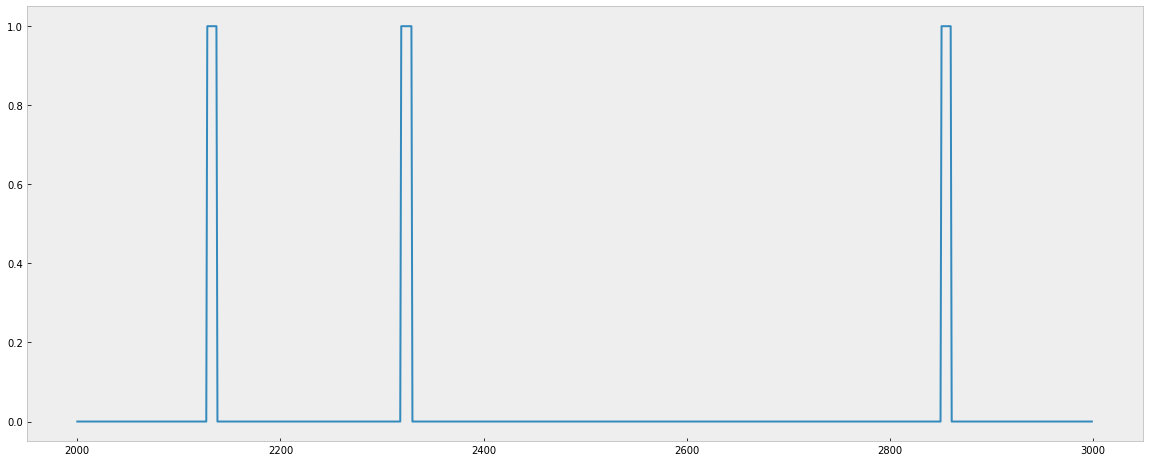

In [ ]:
plt.plot(train_df['target'][2000:3000])

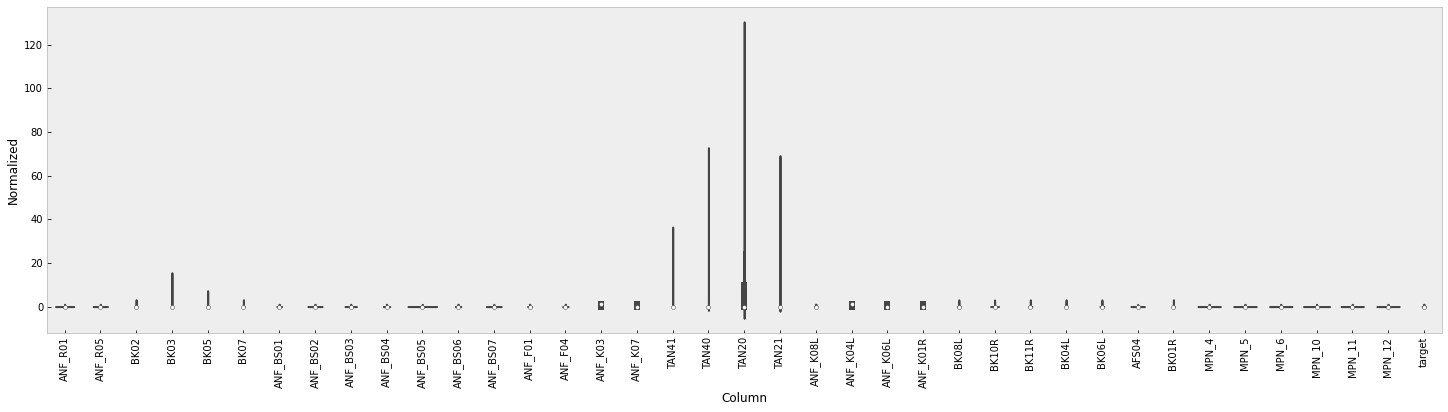

In [ ]:
# plot features before Normalization
df_1 = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(25, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_1)
_ = ax.set_xticklabels(df.keys(), rotation=90)

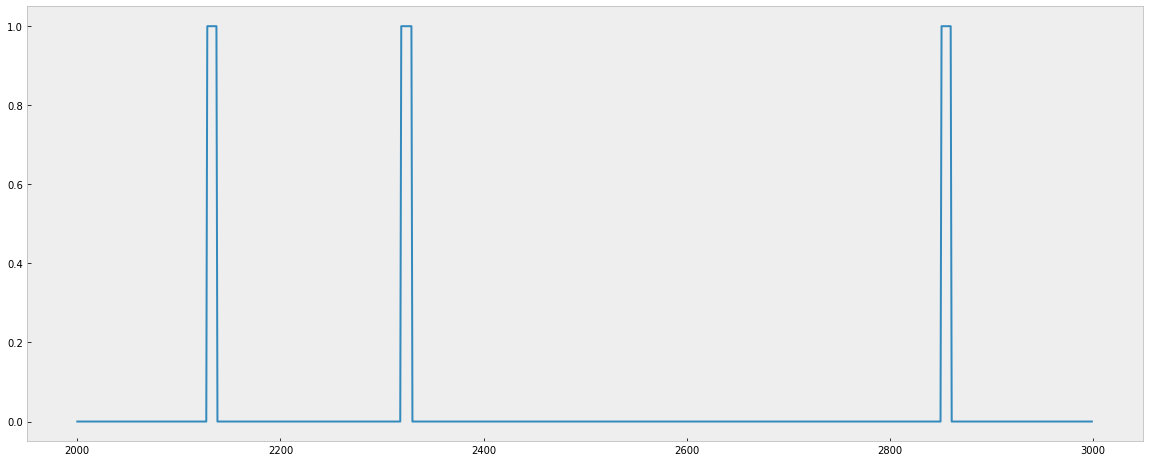

In [ ]:
plt.plot(train_df['target'][2000:3000])

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        #f'Label column name(s): {self.label_columns}'
        ])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='target', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 6))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    marker='o', edgecolors='face', label='Labels', c='#4e8f18', s=84)
        if model is not None:
            # predictions = model.predict(inputs)
            # print(predictions)
            predictions = (model.predict(inputs) > 0.5).astype("int32")
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='*', edgecolors='face', label='Predictions',
                      c='#d1d41c', s=130)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 32
# patience = 5
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                    patience=patience,
                                                    mode='max')

  model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.metrics.BinaryAccuracy()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

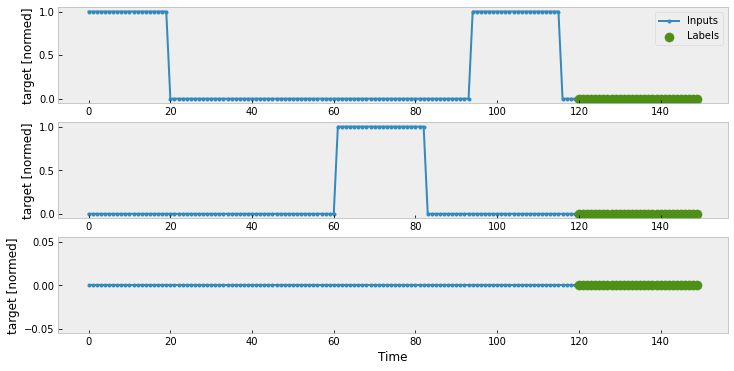

In [ ]:
OUT_STEPS = 30
input_width= 120
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
multi_val_performance = {}
multi_performance = {}

##Dense Model

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros(), activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(multi_step_dense, multi_window)
IPython.display.clear_output()

multi_val_performance['Dense'] = multi_step_dense.evaluate(multi_window.val)
multi_performance['Dense'] = multi_step_dense.evaluate(multi_window.test, verbose=0)

536/536 [==============================] - 2s 3ms/step - loss: 0.0831 - binary_accuracy: 0.8782


1/1 [==============================] - 0s 21ms/step


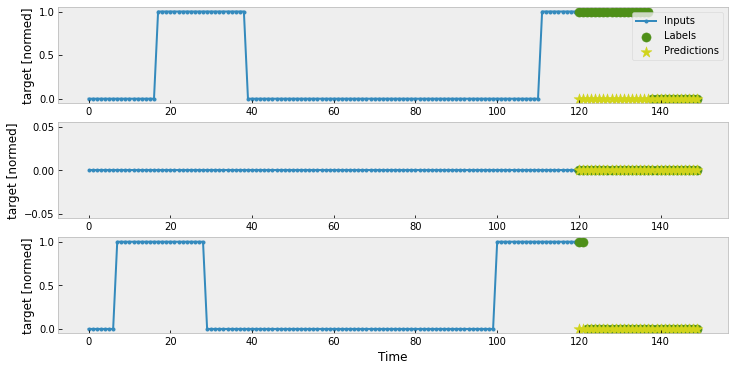

In [ ]:
multi_window.plot(multi_step_dense)

## Baseline Model

1886/1886 [==============================] - 5s 3ms/step - loss: -18.5662 - binary_accuracy: 0.8981 - val_loss: -22.5716 - val_binary_accuracy: 0.8904


1/1 [==============================] - 0s 20ms/step


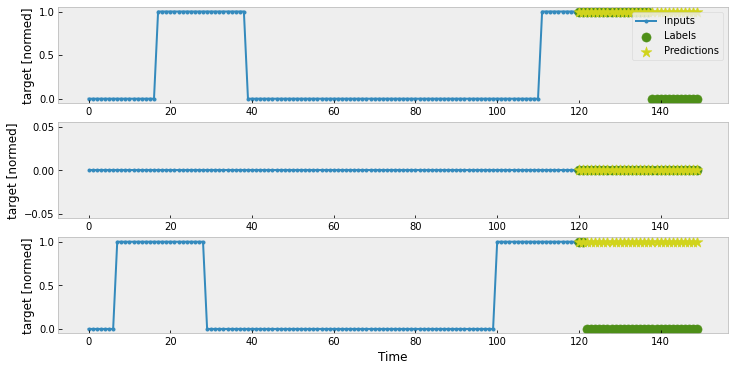

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(#optimizer=tf.optimizers.Adam(),
                      loss= tf.losses.BinaryCrossentropy(from_logits=True),
                      metrics=[tf.metrics.BinaryAccuracy()]
                      )

last_baseline.fit(multi_window.train, epochs=1,
          validation_data=multi_window.val)

multi_val_performance['Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

## Linear Model

1/1 [==============================] - 0s 21ms/step


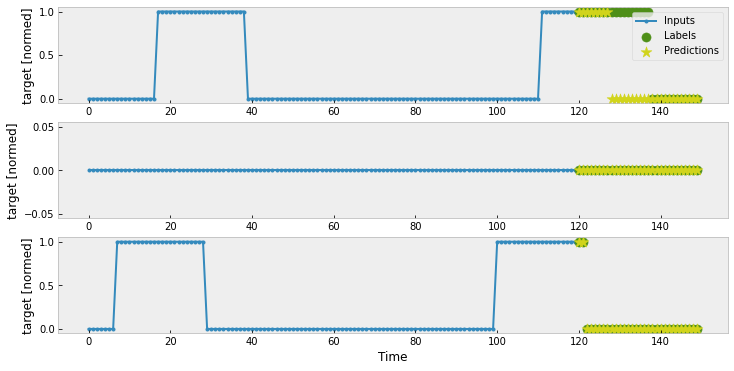

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros , activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## CNN Model

536/536 [==============================] - 2s 3ms/step - loss: 0.0868 - binary_accuracy: 0.8722


1/1 [==============================] - 0s 23ms/step


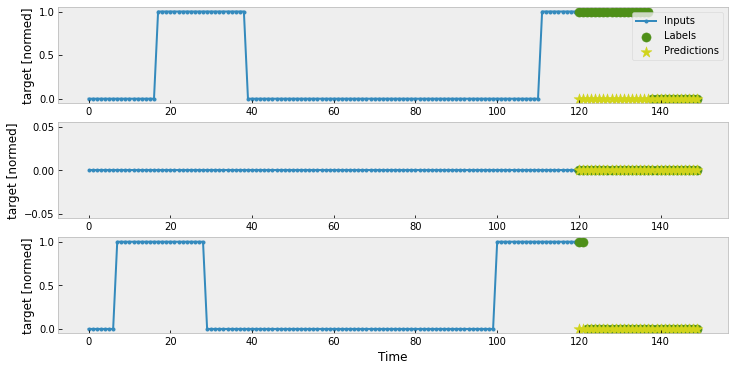

In [ ]:
# CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(120, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros, activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
multi_val_performance['CNN'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN (LSTM) Model

536/536 [==============================] - 2s 4ms/step - loss: 0.0680 - binary_accuracy: 0.9134


1/1 [==============================] - 0s 21ms/step


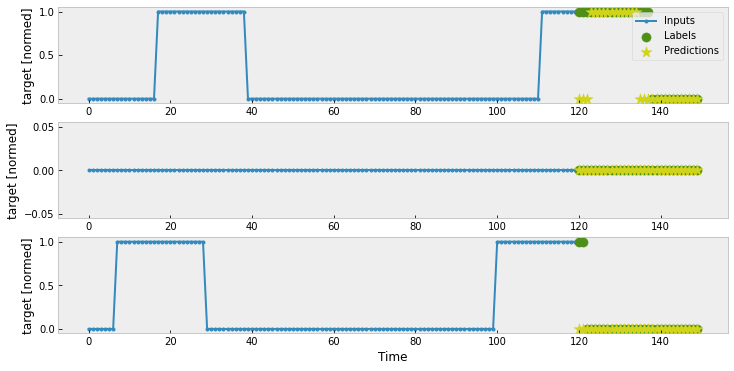

In [ ]:
# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(120, return_sequences=False, activation='tanh'), #tanh
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros() , activation='sigmoid'), #sigmoid
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)
# after trainig, save the model
multi_lstm_model.save('/content/drive/MyDrive/Colab Notebooks/New Features/models/LSTM_model_1Day')

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

# TPR (True Positive Rate) to measure the performance, rather than binary accuracy
multi_window.plot(multi_lstm_model)

## AR-LSTM Model


In [ ]:

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=120, out_steps=OUT_STEPS)

In [ ]:

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)
  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:

prediction, state = feedback_model.warmup(multi_window.example[0])

In [ ]:

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

1/1 [==============================] - 0s 56ms/step


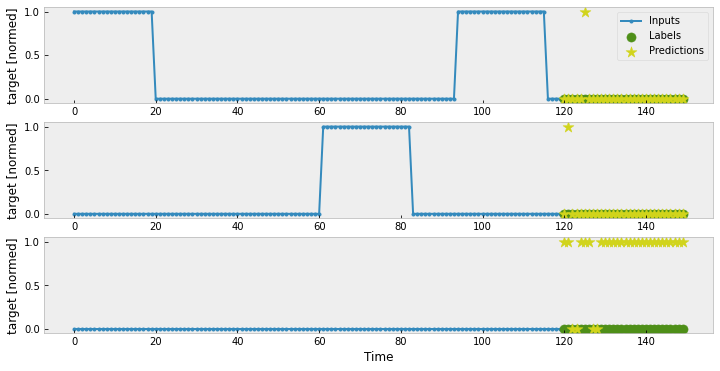

In [ ]:

history = compile_and_fit(feedback_model, multi_window)
IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

## Performance


### Binary Accuracy

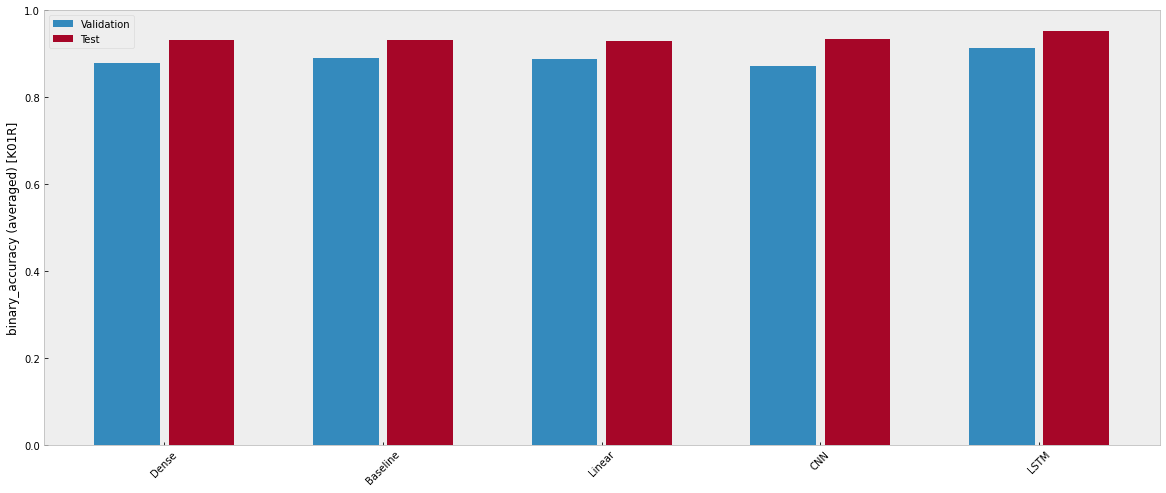

In [ ]:
# performance 

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'binary_accuracy'
metric_index = multi_lstm_model.metrics_names.index('binary_accuracy')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'binary_accuracy (averaged) ' + '['+ trg + ']')
_ = plt.legend()

#### Test Accuracy

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Dense   : 0.9325
Baseline: 0.9312
Linear  : 0.9303
CNN     : 0.9331
LSTM    : 0.9525


In [ ]:
print(multi_performance)

{'Dense': [0.3471224308013916, 0.9324620366096497], 'Baseline': [-13.001317977905273, 0.9311628341674805], 'Linear': [0.3476398289203644, 0.9303061962127686], 'CNN': [0.34748008847236633, 0.9330746531486511], 'LSTM': [0.34245696663856506, 0.9524708390235901]}


#### Validation Accuracy

In [ ]:
for name, value in multi_val_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Dense   : 0.8782
Baseline: 0.8904
Linear  : 0.8869
CNN     : 0.8722
LSTM    : 0.9134


### Basic Metrics



In [ ]:
print('iter: ', len(list(multi_window.test)))

iter:  266


In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
CONV_WIDTH = 3 #for cnn model
# load models if the trained models have been saved before
dense_model_1D = keras.models.load_model('/models/Dense_model_1Day')
baseline_model_1D = keras.models.load_model('/models/Baseline_model_1Day')
linear_model_1D = keras.models.load_model('/models/Linear_model_1Day')
cnn_model_1D = keras.models.load_model('/models/CNN_model_1Day')
lstm_model_1D = keras.models.load_model('/models/LSTM_model_1Day')
ar_lstm_model_1D = feedback_model

# initiation 
y_tests = []

predictions_dense = []
predictions_baseline = []
predictions_linear = []
predictions_cnn = []
predictions_lstm = []
predictions_ar_lstm = []

y_probas_lstm = []
y_probas_dense = []
y_probas_baseline = []
y_probas_linear = []
y_probas_cnn = []
y_probas_ar_lstm =[]

i = 0 
it = iter(multi_window.test)

# 280*30+120 = 8520 < 8640 (length of test set)

for i in range(266): #266
        # get the next value:
        result = next(it)
        inputs, labels = result
        y_test = labels[0, :, multi_window.column_indices['target']]
        y_tests.extend(y_test)

        # -1- Dense Model
        # dense-predictions (binary int)
        prediction_dense = (dense_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_dense.extend(prediction_dense[0, :, multi_window.column_indices['target']])
        # dense-proba (float probability)
        y_proba_dense = dense_model_1D.predict(inputs)        
        y_probas_dense.extend(y_proba_dense[0, :, multi_window.column_indices['target']])

        # -2- Baseline Model
        # baseline-predictions (binary int)
        prediction_baseline = (baseline_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_baseline.extend(prediction_baseline[0, :, multi_window.column_indices['target']])
        # baseline-proba (float probability)
        y_proba_baseline = baseline_model_1D.predict(inputs)        
        y_probas_baseline.extend(y_proba_baseline[0, :, multi_window.column_indices['target']])

        # -3- Linear Model
        # linear-predictions (binary int)
        prediction_linear = (linear_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_linear.extend(prediction_linear[0, :, multi_window.column_indices['target']])
        # linear-proba (float probability)
        y_proba_linear = linear_model_1D.predict(inputs)        
        y_probas_linear.extend(y_proba_linear[0, :, multi_window.column_indices['target']])

        # -4- CNN Model
        # cnn-predictions (binary int)
        prediction_cnn = (cnn_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_cnn.extend(prediction_cnn[0, :, multi_window.column_indices['target']])
        # cnn-proba (float probability)
        y_proba_cnn = cnn_model_1D.predict(inputs)        
        y_probas_cnn.extend(y_proba_cnn[0, :, multi_window.column_indices['target']])

        # -5- LSTM
        # LSTM-predictions (binary int)
        prediction_lstm = (lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_lstm.extend(prediction_lstm[0, :, multi_window.column_indices['target']])
        # LSTM-proba (float probability)
        y_proba_lstm = lstm_model_1D.predict(inputs)        
        y_probas_lstm.extend(y_proba_lstm[0, :, multi_window.column_indices['target']])

        # -6- AR-LSTM
        # AR LSTM-predictions (binary int)
        prediction_ar_lstm = (ar_lstm_model_1D.predict(inputs) > 0.5).astype("int32")
        predictions_ar_lstm.extend(prediction_ar_lstm[0, :, multi_window.column_indices['target']])
        # AR LSTM-proba (float probability)
        y_proba_ar_lstm = ar_lstm_model_1D.predict(inputs)        
        y_probas_ar_lstm.extend(y_proba_ar_lstm[0, :, multi_window.column_indices['target']])


# already obtained: y_preds, y_tests, y_probas
# -1- Dense Model
acc_dense = metrics.accuracy_score(y_tests, predictions_dense)
ppv_dense = metrics.precision_score(y_tests, predictions_dense)
tpr_dense = metrics.recall_score(y_tests, predictions_dense)
f1_dense = metrics.f1_score(y_tests, predictions_dense)
mcc_dense = metrics.matthews_corrcoef(y_tests, predictions_dense)
# confusion matrix
conf_dense = metrics.confusion_matrix(y_tests, predictions_dense)

# -2- Baseline Model
acc_baseline = metrics.accuracy_score(y_tests, predictions_baseline)
ppv_baseline = metrics.precision_score(y_tests, predictions_baseline)
tpr_baseline = metrics.recall_score(y_tests, predictions_baseline)
f1_baseline = metrics.f1_score(y_tests, predictions_baseline)
mcc_baseline = metrics.matthews_corrcoef(y_tests, predictions_baseline)
conf_baseline = metrics.confusion_matrix(y_tests, predictions_baseline)

# -3- Linear Model
acc_linear = metrics.accuracy_score(y_tests, predictions_linear)
ppv_linear = metrics.precision_score(y_tests, predictions_linear)
tpr_linear = metrics.recall_score(y_tests, predictions_linear)
f1_linear = metrics.f1_score(y_tests, predictions_linear)
mcc_linear = metrics.matthews_corrcoef(y_tests, predictions_linear)
conf_linear = metrics.confusion_matrix(y_tests, predictions_linear)

# -4- CNN Model
acc_cnn = metrics.accuracy_score(y_tests, predictions_cnn)
ppv_cnn = metrics.precision_score(y_tests, predictions_cnn)
tpr_cnn = metrics.recall_score(y_tests, predictions_cnn)
f1_cnn = metrics.f1_score(y_tests, predictions_cnn)
mcc_cnn = metrics.matthews_corrcoef(y_tests, predictions_cnn)
conf_cnn = metrics.confusion_matrix(y_tests, predictions_cnn)

# -5- LSTM
acc_lstm = metrics.accuracy_score(y_tests, predictions_lstm)
ppv_lstm = metrics.precision_score(y_tests, predictions_lstm)
tpr_lstm = metrics.recall_score(y_tests, predictions_lstm)
f1_lstm = metrics.f1_score(y_tests, predictions_lstm)
mcc_lstm = metrics.matthews_corrcoef(y_tests, predictions_lstm)
conf_lstm = metrics.confusion_matrix(y_tests, predictions_lstm)

# -6- AR-LSTM

acc_ar_lstm = metrics.accuracy_score(y_tests, predictions_ar_lstm)
ppv_ar_lstm = metrics.precision_score(y_tests, predictions_ar_lstm)
tpr_ar_lstm = metrics.recall_score(y_tests, predictions_ar_lstm)
f1_ar_lstm = metrics.f1_score(y_tests, predictions_ar_lstm)
mcc_ar_lstm = metrics.matthews_corrcoef(y_tests, predictions_ar_lstm)
conf_ar_lstm = metrics.confusion_matrix(y_tests, predictions_ar_lstm)

print("-1- Dense Model")
print(f"Accuracy (ACC):                {acc_dense: .3f}")
print(f"Precision score (PPV):            {ppv_dense: .3f}")
print(f"Recall score (TPR):             {tpr_dense: .3f}")
print(f"F1 score:                   {f1_dense: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_dense: .3f}")
print("confusion matrix: ", conf_dense)

print("-2- Baseline Model")
print(f"Accuracy (ACC):                {acc_baseline: .3f}")
print(f"Precision score (PPV):            {ppv_baseline: .3f}")
print(f"Recall score (TPR):             {tpr_baseline: .3f}")
print(f"F1 score:                   {f1_baseline: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_baseline: .3f}")
print('confusion matrix: ', conf_baseline)

print("-3- Linear Model")
print(f"Accuracy (ACC):                {acc_linear: .3f}")
print(f"Precision score (PPV):            {ppv_linear: .3f}")
print(f"Recall score (TPR):             {tpr_linear: .3f}")
print(f"F1 score:                   {f1_linear: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_linear: .3f}")
print("confusion matrix: ", conf_linear)

print("-4- CNN Model")
print(f"Accuracy (ACC):                {acc_cnn: .3f}")
print(f"Precision score (PPV):            {ppv_cnn: .3f}")
print(f"Recall score (TPR):             {tpr_cnn: .3f}")
print(f"F1 score:                   {f1_cnn: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_cnn: .3f}")
print("confusion matrix: ", conf_cnn)

print("-5- LSTM Model")
print(f"Accuracy (ACC):                {acc_lstm: .3f}")
print(f"Precision score (PPV):            {ppv_lstm: .3f}")
print(f"Recall score (TPR):             {tpr_lstm: .3f}")
print(f"F1 score:                   {f1_lstm: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_lstm: .3f}")
print("confusion matrix: ", conf_lstm)

print("-6- AR-LSTM Model")
print(f"Accuracy (ACC):                {acc_ar_lstm: .3f}")
print(f"Precision score (PPV):            {ppv_ar_lstm: .3f}")
print(f"Recall score (TPR):             {tpr_ar_lstm: .3f}")
print(f"F1 score:                   {f1_ar_lstm: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_ar_lstm: .3f}")
print("confusion matrix: ", conf_ar_lstm)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-1- Dense Model
Accuracy (ACC):                 0.894
Precision score (PPV):             0.000
Recall score (TPR):              0.000
F1 score:                    0.000
Matthew's correlation coefficient (MCC):   0.000
confusion matrix:  [[7138    0]
 [ 842    0]]
-2- Baseline Model
Accuracy (ACC):                 0.856
Precision score (PPV):             0.277
Recall score (TPR):              0.227
F1 score:                    0.249
Matthew's correlation coefficient (MCC):   0.172
confusion matrix:  [[6639  499]
 [ 651  191]]
-3- Linear Model
Accuracy (ACC):                 0.911
Precision score (PPV):             0.722
Recall score (TPR):              0.249
F1 score:                    0.371
Matthew's correlation coefficient (MCC):   0.390
confusion matrix:  [[7057   81]
 [ 632  210]]
-4- CNN Model
Accuracy (ACC):                 0.894
Precision score (PPV):             0.000
Recall score (TPR):              0.000
F1 score:                    0.000
Matthew's correlation coefficient (MC

#### Accuracy (ACC)

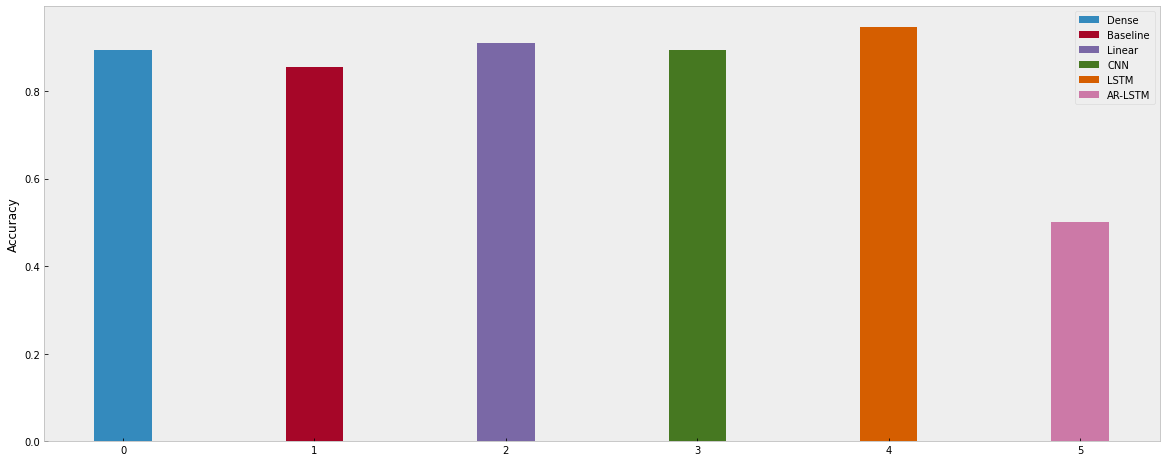

In [ ]:
# plot comparison results of these six models
# plot accuracy ACC
width = 0.3
plt.bar(0, acc_dense, width, label='Dense')
plt.bar(1, acc_baseline, width, label='Baseline')
plt.bar(2, acc_linear, width, label='Linear')
plt.bar(3, acc_cnn, width, label='CNN')
plt.bar(4, acc_lstm, width, label='LSTM')
plt.bar(5, acc_ar_lstm, width, label='AR-LSTM')
plt.ylabel(f'Accuracy')
_ = plt.legend()
plt.show()

#### Precision Score (PPV)

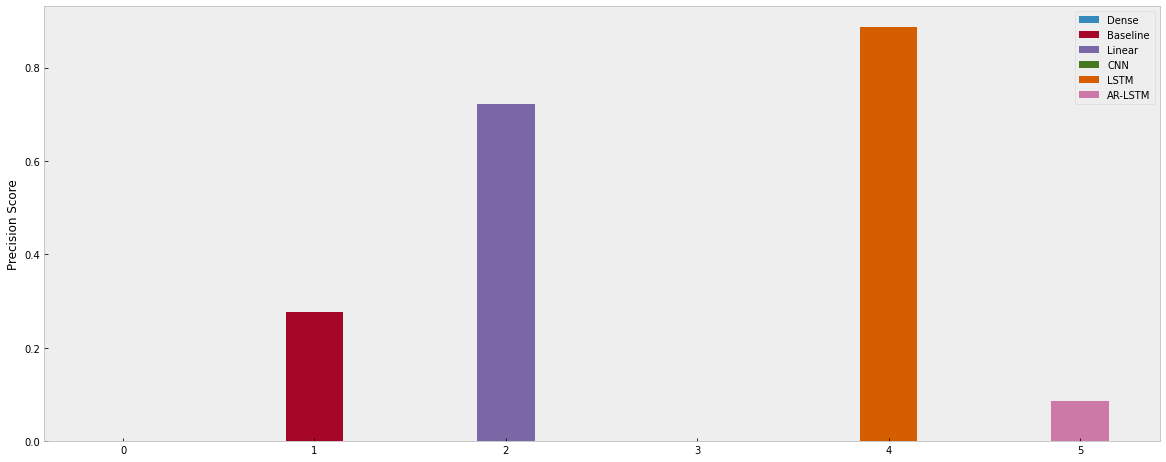

In [ ]:
# plot precision score (PPV)
width = 0.3
plt.bar(0, ppv_dense, width, label='Dense')
plt.bar(1, ppv_baseline, width, label='Baseline')
plt.bar(2, ppv_linear, width, label='Linear')
plt.bar(3, ppv_cnn, width, label='CNN')
plt.bar(4, ppv_lstm, width, label='LSTM')
plt.bar(5, ppv_ar_lstm, width, label='AR-LSTM')
plt.ylabel(f'Precision Score')
_ = plt.legend()
plt.show()

#### Recall Score (TPR)

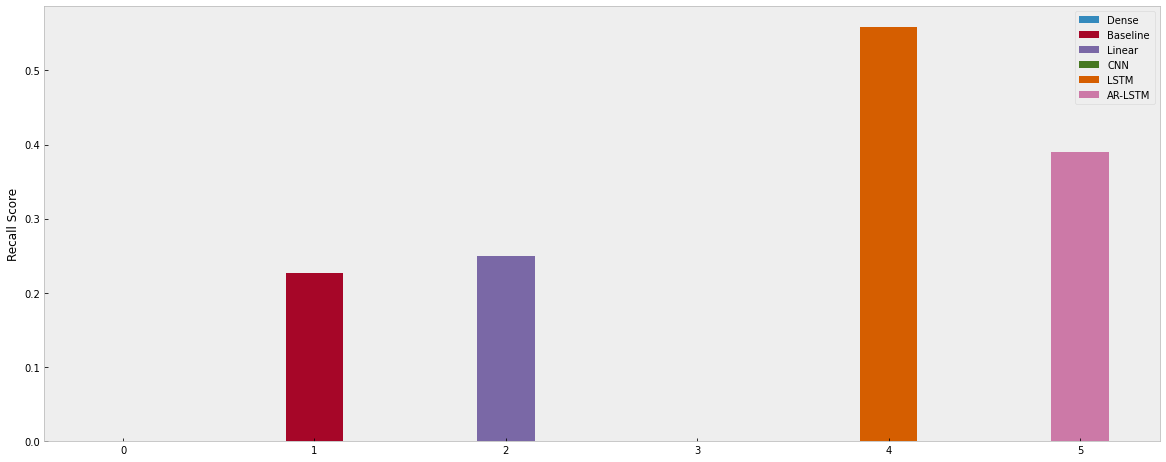

In [ ]:
# plot recall score (TPR)
width = 0.3
plt.bar(0, tpr_dense, width, label='Dense')
plt.bar(1, tpr_baseline, width, label='Baseline')
plt.bar(2, tpr_linear, width, label='Linear')
plt.bar(3, tpr_cnn, width, label='CNN')
plt.bar(4, tpr_lstm, width, label='LSTM')
plt.bar(5, tpr_ar_lstm, width, label='AR-LSTM')
plt.ylabel(f'Recall Score')
_ = plt.legend()
plt.show()

#### F1 Score

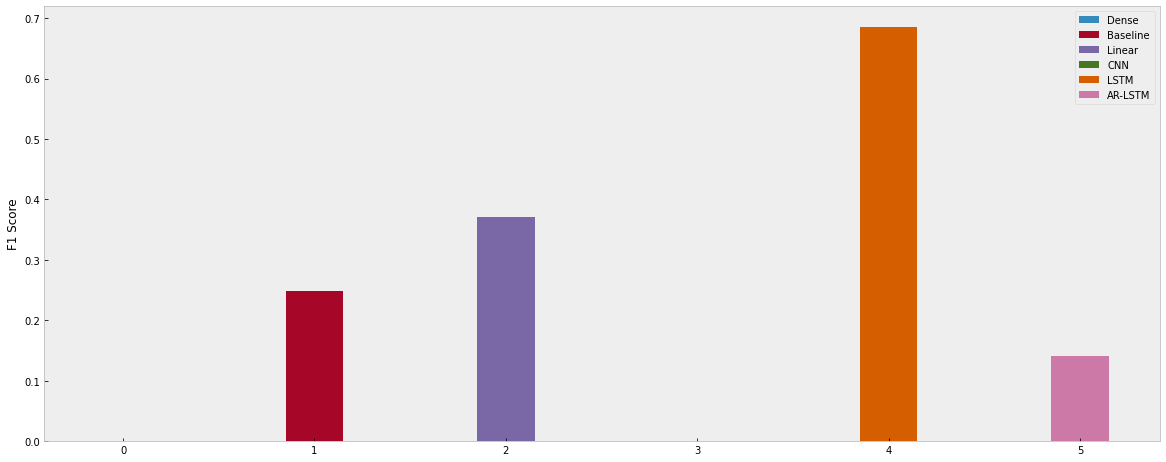

In [ ]:
# plot F1 score
width = 0.3
plt.bar(0, f1_dense, width, label='Dense')
plt.bar(1, f1_baseline, width, label='Baseline')
plt.bar(2, f1_linear, width, label='Linear')
plt.bar(3, f1_cnn, width, label='CNN')
plt.bar(4, f1_lstm, width, label='LSTM')
plt.bar(5, f1_ar_lstm, width, label='AR-LSTM')
plt.ylabel(f'F1 Score')
_ = plt.legend()
plt.show()

#### Matthew's correlation coefficient (MCC)

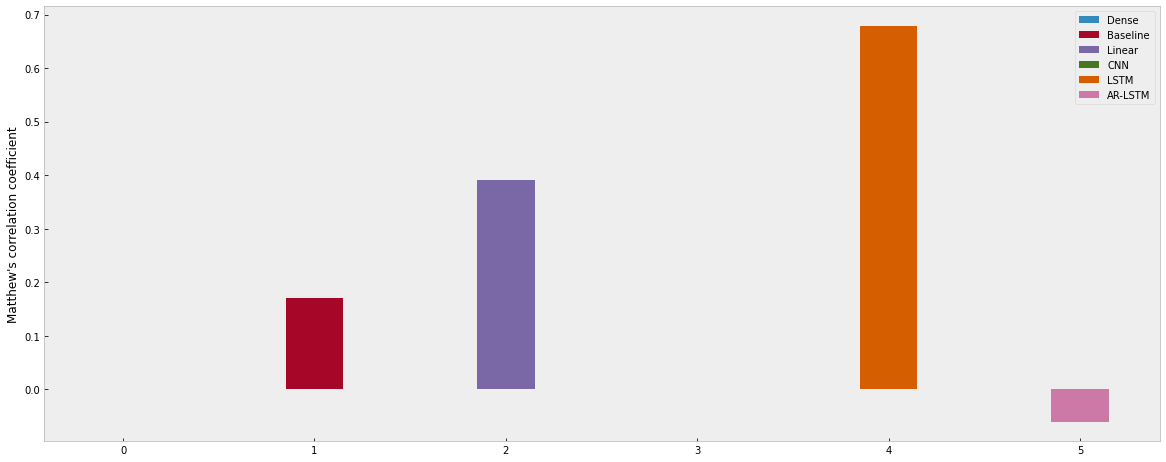

In [ ]:
# plot Matthews correlation coefficient
width = 0.3
plt.bar(0, mcc_dense, width, label='Dense')
plt.bar(1, mcc_baseline, width, label='Baseline')
plt.bar(2, mcc_linear, width, label='Linear')
plt.bar(3, mcc_cnn, width, label='CNN')
plt.bar(4, mcc_lstm, width, label='LSTM')
plt.bar(5, mcc_ar_lstm, width, label='AR-LSTM')
plt.ylabel(f'Matthew\'s correlation coefficient')
_ = plt.legend()
plt.show()

#### ROC curve (Receiver Operating Characteristic curve)

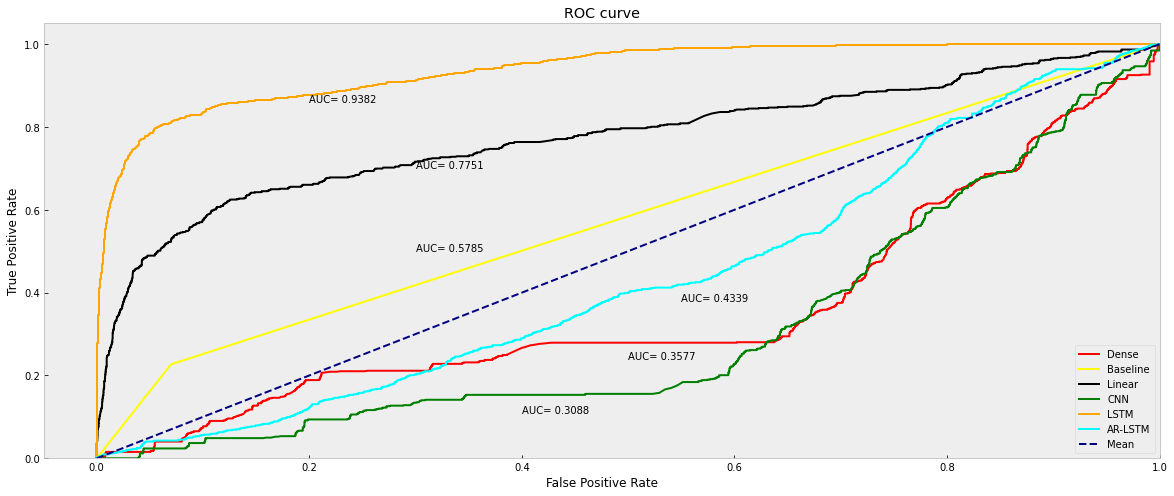

In [ ]:
FPRs_dense, TPRs_dense, _ = roc_curve(y_tests, y_probas_dense)
FPRs_baseline, TPRs_baseline, _ = roc_curve(y_tests, y_probas_baseline)
FPRs_linear, TPRs_linear, _ = roc_curve(y_tests, y_probas_linear)
FPRs_cnn, TPRs_cnn, _ = roc_curve(y_tests, y_probas_cnn)
FPRs_lstm, TPRs_lstm, _ = roc_curve(y_tests, y_probas_lstm)
FPRs_ar_lstm, TPRs_ar_lstm, _ = roc_curve(y_tests, y_probas_ar_lstm)

# ROC-AUC
auc_score_dense = metrics.roc_auc_score(y_tests, y_probas_dense)
auc_score_baseline = metrics.roc_auc_score(y_tests, y_probas_baseline)
auc_score_linear = metrics.roc_auc_score(y_tests, y_probas_linear)
auc_score_cnn = metrics.roc_auc_score(y_tests, y_probas_cnn)
auc_score_lstm = metrics.roc_auc_score(y_tests, y_probas_lstm)
auc_score_ar_lstm = metrics.roc_auc_score(y_tests, y_probas_ar_lstm)

# Plot the ROC curve
plt.plot(FPRs_dense, TPRs_dense, color='red', lw=2, label='Dense')
plt.annotate(f'AUC={auc_score_dense: .4f}', xy=(0.5,0.24) ) # xy is added mannualy
plt.plot(FPRs_baseline, TPRs_baseline, color='yellow', lw=2, label='Baseline')
plt.annotate(f'AUC={auc_score_baseline: .4f}', xy=(0.3,0.5) )
plt.plot(FPRs_linear, TPRs_linear, color='black', lw=2, label='Linear')
plt.annotate(f'AUC={auc_score_linear: .4f}', xy=(0.3,0.7) )
plt.plot(FPRs_cnn, TPRs_cnn, color='green', lw=2, label='CNN')
plt.annotate(f'AUC={auc_score_cnn: .4f}', xy=(0.4,0.11) )
plt.plot(FPRs_lstm, TPRs_lstm, color='orange', lw=2, label='LSTM')
plt.annotate(f'AUC={auc_score_lstm: .4f}', xy=(0.2,0.86) )
plt.plot(FPRs_ar_lstm, TPRs_ar_lstm, color='cyan', lw=2, label='AR-LSTM')
plt.annotate(f'AUC={auc_score_ar_lstm: .4f}', xy=(0.55,0.38) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### ROC-AUC Score

Now, that we know about ROC curve, what it represents, **AUC score** is very easy to understand.  
AUC stands for **Area under the Curve**, which is nothing but the area under the ROC curve formed by the predictions.  
As we saw, a totally random prediction will have AUC score `0.5`, while a perfect classifier will have AUC score of `1`. 

In [ ]:

print(f"ROC-AUC score of Dense Model is {auc_score_dense: .4f}")
print(f"ROC-AUC score of Baseline Model is {auc_score_baseline: .4f}")
print(f"ROC-AUC score of Linear Model is {auc_score_linear: .4f}")
print(f"ROC-AUC score of CNN Model is {auc_score_cnn: .4f}")
print(f"ROC-AUC score of LSTM Model is {auc_score_lstm: .4f}")
print(f"ROC-AUC score of AR-LSTM Model is {auc_score_ar_lstm: .4f}")

ROC-AUC score of Dense Model is  0.3577
ROC-AUC score of Baseline Model is  0.5785
ROC-AUC score of Linear Model is  0.7751
ROC-AUC score of CNN Model is  0.3088
ROC-AUC score of LSTM Model is  0.9382
ROC-AUC score of AR-LSTM Model is  0.4339
